<a href="https://colab.research.google.com/github/cmannnn/predict_future_sales/blob/main/predict_future_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Future Sales

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

# File descriptions

itemcats_df - supplemental information about the items categories.

items_df - supplemental information about the items/products.

salestrain_df - the training set. Daily historical data from January 2013 to October 2015.

shops_df - supplemental information about the shops.

test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

sample_submission.csv - a sample submission file in the correct format.

# Imports

In [7]:
# imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#import specific sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

In [8]:
#!pip install kaggle

In [9]:
# UPLOAD YOUR kaggle.json KEY HERE

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [10]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         82           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        174           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        407           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2720           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      21604            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       5466           False  
connectx

In [11]:
!mkdir -p predict_future_sales

In [12]:
# UPLOAD 6 FILES HERE
uploaded2 = files.upload()

Saving item_categories.csv to item_categories (1).csv
Saving items.csv to items (1).csv
Saving sample_submission.csv to sample_submission (1).csv
Saving sales_train.csv to sales_train (1).csv
Saving shops.csv to shops.csv
Saving test.csv to test.csv


In [13]:
!cp test.csv predict_future_sales/
!cp item_categories.csv predict_future_sales/
!cp items.csv predict_future_sales/
!cp sales_train.csv predict_future_sales/
!cp sample_submission.csv predict_future_sales/
!cp shops.csv predict_future_sales/
!cp test.csv predict_future_sales/

# Importing All Predict Sales Data

In [14]:
#importing all the data frames
itemcats_df = pd.read_csv("predict_future_sales/item_categories.csv") #Item Categories
items_df = pd.read_csv("predict_future_sales/items.csv", encoding='unicode_escape') # Items
salestrain_df = pd.read_csv("predict_future_sales/sales_train.csv") #Sales Data - Training
shops_df = pd.read_csv("predict_future_sales/shops.csv", encoding='unicode_escape') # Shops

In [15]:
# sample submission dataframe
sample_df = pd.read_csv('predict_future_sales/sample_submission.csv')

# test data frame
test_df = pd.read_csv('predict_future_sales/test.csv')

# Data EDA

In [16]:
# creating a master list of all dataframes
df_list = [itemcats_df, items_df, salestrain_df, shops_df]

In [17]:
# creating a loop to print head, description, info, and null sum for each datafram in master list 
for df in df_list:
    print(f'DATAFRAME HEAD: {df.head()}')
    print('-----------------------')
    print(f'DATAFRAME DESCRIPTION: {df.describe()}')
    print('-----------------------')
    print(f'DATAFAME INFO: {df.info()}')
    print('-----------------------')
    print(f'DATAFRAME NULL SUM: {df.isnull().sum()}')
    print('------------------------------------------------------------------------------')

DATAFRAME HEAD:            item_category_name  item_category_id
0  PC - Headsets / Headphones                 0
1           Accessories - PS2                 1
2           Accessories - PS3                 2
3           Accessories - PS4                 3
4           Accessories - PSP                 4
-----------------------
DATAFRAME DESCRIPTION:        item_category_id
count         84.000000
mean          41.500000
std           24.392622
min            0.000000
25%           20.750000
50%           41.500000
75%           62.250000
max           83.000000
-----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
DATAFAME INFO: None
-----------------------
DATAFRAME NULL SUM: i

In [18]:
# checking itemcats_df column data types
itemcats_df.dtypes

item_category_name    object
item_category_id       int64
dtype: object

In [19]:
# checking item_df column data types
items_df.dtypes

item_name           object
item_id              int64
item_category_id     int64
dtype: object

In [20]:
# checking salestrain_df data types
salestrain_df.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id           float64
item_price        float64
item_cnt_day      float64
dtype: object

In [21]:
# changing salestrain 'item_cnt_day' col from float64 -> int16
salestrain_df['item_cnt_day'] = pd.to_numeric(salestrain_df['item_cnt_day'], downcast='signed')

In [22]:
# changing salestrain 'date' col from object -> datetime
salestrain_df['date'] = pd.to_datetime(salestrain_df['date'])

In [23]:
shops_df.dtypes

shop_name    object
shop_id       int64
dtype: object

# Combine DFs

In [24]:
# combining training dataframes into master training set
salestrain_df_combined = salestrain_df.merge(items_df,on='item_id')
salestrain_df_combined = salestrain_df_combined.merge(itemcats_df,on='item_category_id')
salestrain_df_combined = salestrain_df_combined.merge(shops_df,on='shop_id')

In [25]:
salestrain_df_combined.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
dtype: int64

In [26]:
# setting the id col, and 2 target cols based on testing data
id_col, target_col_item, target_col_shop = salestrain_df.index, salestrain_df_combined['item_id'], salestrain_df_combined['shop_id']

# Data Viz

In [27]:
# adding features for separating date
salestrain_df_combined['year'] = salestrain_df_combined.date.dt.year
salestrain_df_combined['month'] = salestrain_df_combined.date.dt.month
salestrain_df_combined['day'] = salestrain_df_combined.date.dt.day

# adding revenue feature
salestrain_df_combined['revenue'] = salestrain_df_combined.item_price * salestrain_df_combined.item_cnt_day
salestrain_df_combined.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
0,2013-02-01,0,59,22154.0,999.0,1.0,Scene 2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,1,999.0
1,2013-04-26,3,59,944.0,150.0,1.0,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,4,26,150.0
2,2013-06-26,5,59,944.0,199.5,1.0,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,26,199.5
3,2013-07-20,6,59,944.0,199.5,1.0,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,7,20,199.5
4,2013-09-14,8,59,944.0,299.0,2.0,2012 (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,9,14,598.0


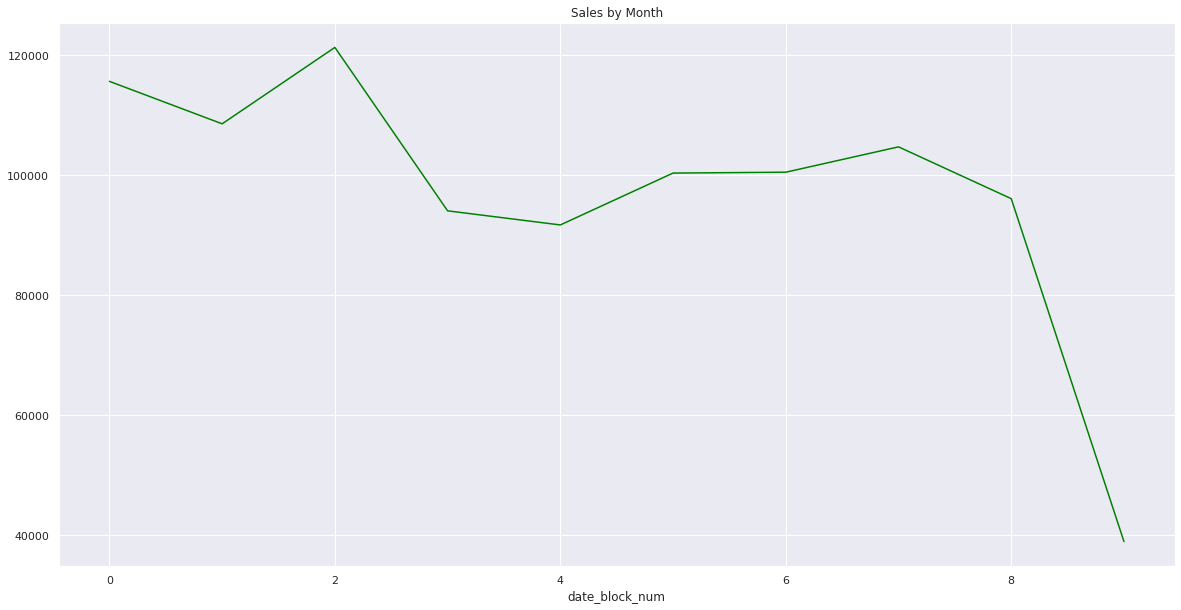

In [28]:
sns.set()
salestrain_df_combined.groupby('date_block_num').date.count().plot.line(title='Sales by Month', color='green', figsize=(20, 10))

As we can see, sales are decreasing through the years. 
We also see a spike sale during december. 
Since, the dataset is up to October, are we seeing some spike in year 2015?

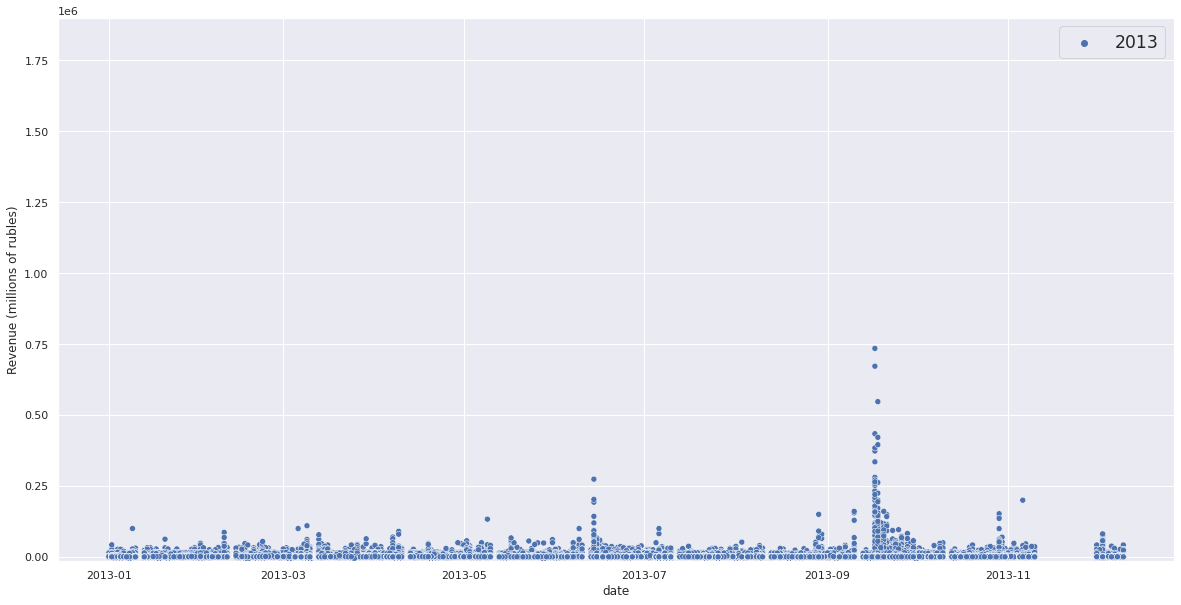

In [29]:
# time series scatterplot of revenue highlighting years
plt.figure(figsize = (20, 10))
sns.scatterplot(x = salestrain_df_combined['date'], y = salestrain_df_combined['revenue'], hue = salestrain_df_combined['year'], palette='deep')
plt.ylim(salestrain_df_combined['revenue'].min(), 1900000)
#plt.arrow(2013-11-29, 1829990.0000013, 2013-11-30, 1700000, head_width = 10, head_length = 11)
#plt.axvline()
plt.ylabel('Revenue (millions of rubles)')
plt.legend(fontsize='x-large')
plt.show()

In [30]:
# printing most amount of revenue and least amount of revenue
print(f'The least amount of revenue recorded is: {salestrain_df_combined.revenue.min()}')
print(f'The most amount of revenue recorded is: {salestrain_df_combined.revenue.max()}')

The least amount of revenue recorded is: -15594.0
The most amount of revenue recorded is: 734571.99999936


In [39]:
# day with the highest amount of revenue
print('The date with the most amount of revenue is:', salestrain_df_combined.loc[salestrain_df_combined['revenue'] == 734571.99999936, 'date'].values[0])

The date with the most amount of revenue is: 2013-09-17T00:00:00.000000000


In [40]:
# masking revenue numbers to show negative revenue
# not sure how to have negative revenue
# item returns?
salestrain_neg_mask = salestrain_df_combined['revenue'] < 0
salestrain_df_combined[salestrain_neg_mask].head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day,revenue
87,2013-02-25,1,59,10308.0,399.00,-1.0,GANGSTER (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,2,25,-399.00
97,2013-06-20,5,59,14549.0,149.00,-1.0,The meeting place can not be changed e (BD),37,Movie - Blu-Ray,"Yaroslavl shopping center ""Altair""",2013,6,20,-149.00
902,2013-06-28,5,59,5500.0,1449.00,-1.0,PINK FLOYD The Wall Original Recording Remaste...,56,Music - CD production firm,"Yaroslavl shopping center ""Altair""",2013,6,28,-1449.00
1955,2013-06-08,7,59,14377.0,199.00,-1.0,Martinov Evgeniy Golden Collection Retro,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2013,6,8,-199.00
2344,2013-08-06,5,59,18584.0,199.00,-1.0,Secret Secret 30 (firms).,55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2013,8,6,-199.00
2476,2013-06-15,5,59,2641.0,299.00,-1.0,DJ FEEL Unlimited 2CD (digipack),55,Music - CD of local production,"Yaroslavl shopping center ""Altair""",2013,6,15,-299.00
2687,2013-05-14,4,59,5034.0,1199.00,-1.0,"NHL 13 [Xbox 360, Russian documentation]",23,Games - XBOX 360,"Yaroslavl shopping center ""Altair""",2013,5,14,-1199.00
2708,2013-12-02,1,59,4885.0,899.00,-1.0,Mortal Kombat (Classics) [Xbox 360 records Rus...,23,Games - XBOX 360,"Yaroslavl shopping center ""Altair""",2013,12,2,-899.00
3135,2013-08-16,7,59,2680.0,561.97,-1.0,DanceStar Party (Essentials) (only for PS Move...,19,Games - PS3,"Yaroslavl shopping center ""Altair""",2013,8,16,-561.97
3140,2013-03-22,2,59,2437.0,823.01,-1.0,"Crysis 2 (with support for 3D) [PS3, Russian v...",19,Games - PS3,"Yaroslavl shopping center ""Altair""",2013,3,22,-823.01


In [41]:
# grouping revenue by month and rounding number
monthly_group = salestrain_df_combined.groupby(by=['month'])
monthly_group_sum = monthly_group['revenue'].sum().round()      
monthly_group_sum                   

month
1      70408024.0
2      84892543.0
3      90591315.0
4      64979551.0
5      67181422.0
6      77171711.0
7      70796121.0
8      75190418.0
9     109425466.0
10     47494409.0
11     22688809.0
12     25442699.0
Name: revenue, dtype: float64

In [42]:
# normalizing data for visualization
monthly_group_norm = (monthly_group_sum - monthly_group_sum.mean()) / (monthly_group_sum.max() - monthly_group_sum.min())
monthly_group_norm = abs(monthly_group_norm)
monthly_group_norm

month
1     0.037118
2     0.204112
3     0.269814
4     0.025468
5     0.000082
6     0.115097
7     0.041592
8     0.092255
9     0.486956
10    0.227057
11    0.513044
12    0.481294
Name: revenue, dtype: float64

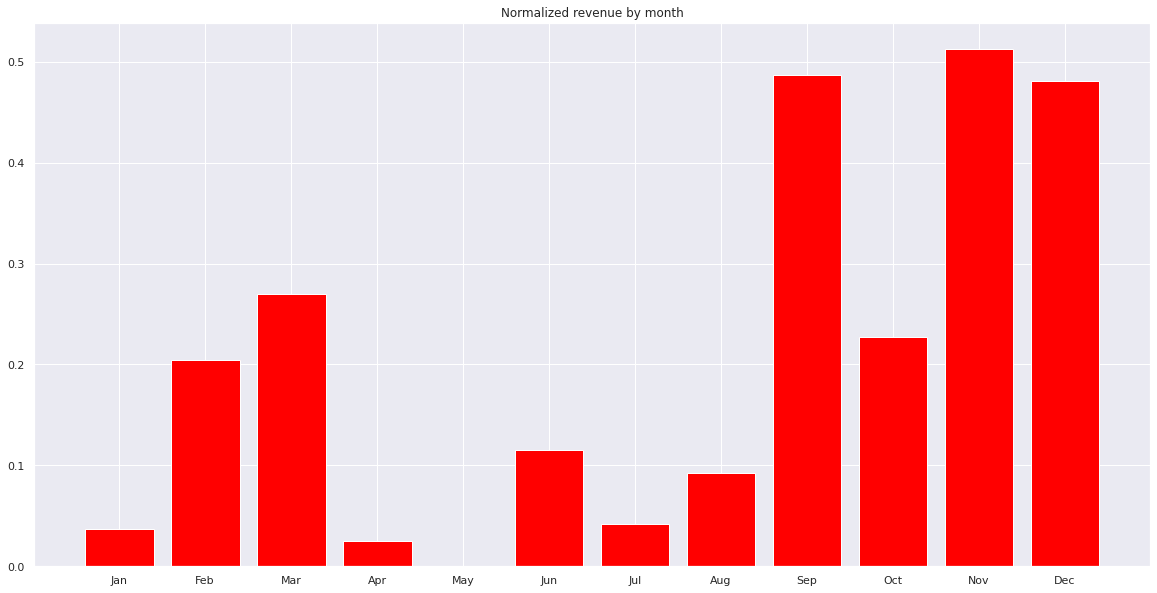

In [43]:
# graphing normalized revenue
# look at those december sales!!
ax, fig = plt.subplots(figsize=(20,10))
cols = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.bar(cols, monthly_group_norm, color='red')
plt.title('Normalized revenue by month')
plt.show()

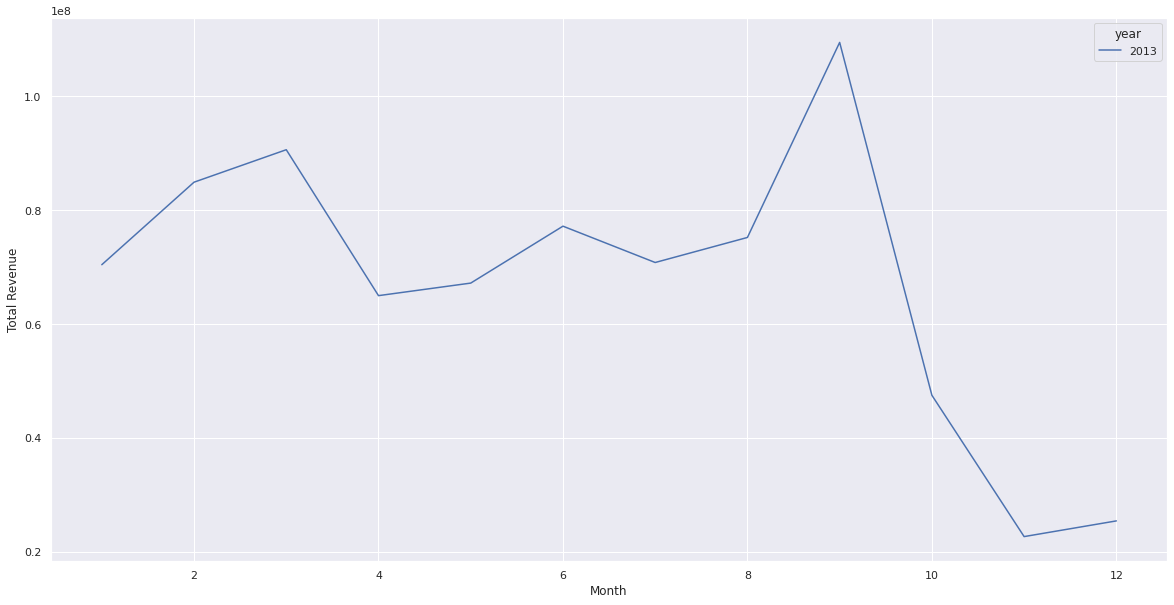

In [44]:
# Plot total revenue by month for each year
salestrain_df_combined.groupby(['month', 'year']).sum()['revenue'].unstack().plot(figsize=(20, 10))
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

There are no sales spike on december 2015.

In [45]:
# creating list of top selling items
top_items = [20949, 5822, 17717, 2808, 4181, 7856, 3732, 2308, 4870, 3734]

# creating empty list to append to
top_item_cols = []

# loop to append item name based on top selling items
for items in top_items:
  top_item_cols.append(salestrain_df_combined.loc[salestrain_df_combined['item_id'] == items, 'item_name'].values[0])

top_item_cols

['Corporate package white shirt 1C Interest (34 * 42) 45 m',
 'Playstation Store replenishment wallet: Map payment of 1000 rubles.',
 'Receiving cash for 1C-line',
 'Diablo III [PC, Jewel, Russian version]',
 'Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box',
 'World of Warcraft. possession of payment card (online) (rus.v.) (60 days) (Jewel)',
 'Grand Theft Auto V [PS3, Russian subtitles]',
 'Call of Duty: Black Ops II [Pc, Jewel, Russian version]',
 'Minecraft [Xbox 360, English version]',
 'Grand Theft Auto V [Xbox 360, Russian subtitles]']

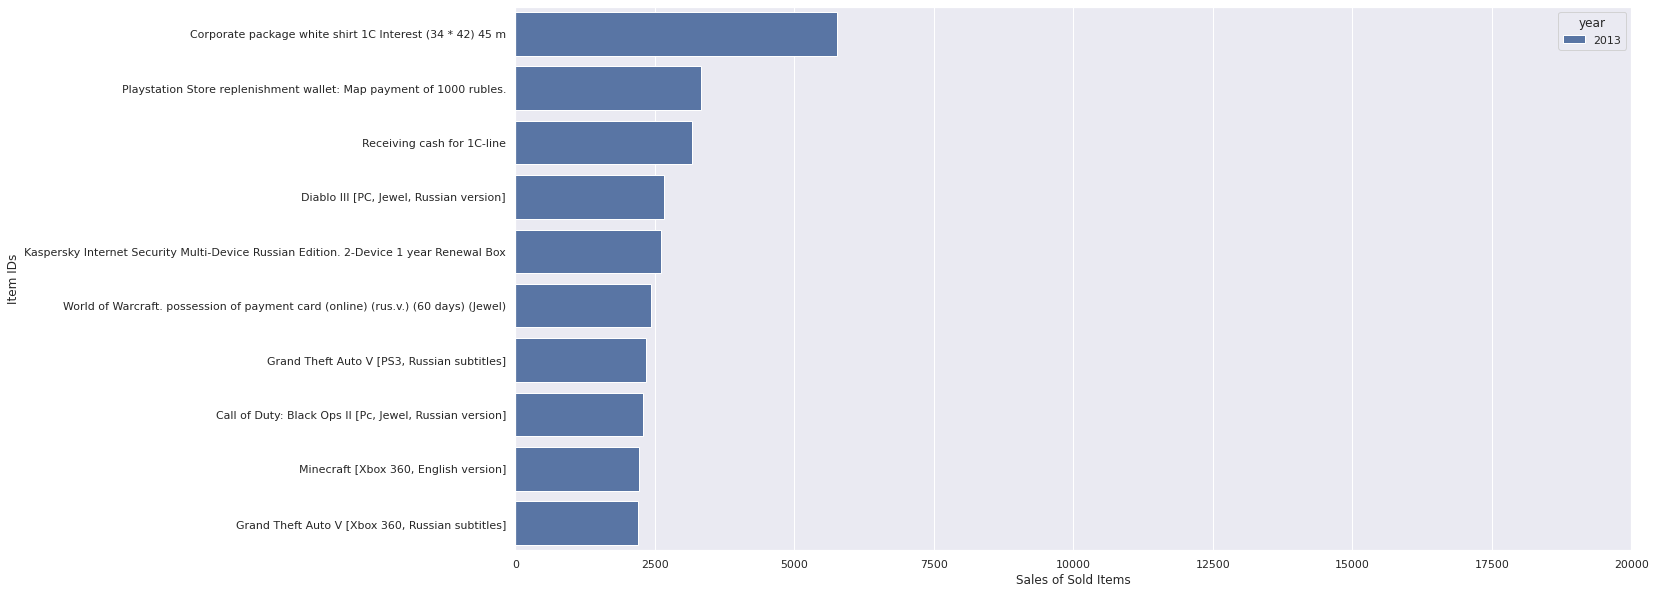

In [46]:
# Plot the top 10 most items sold
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(y = 'item_id', hue = 'year', data = salestrain_df_combined, order = salestrain_df_combined['item_id'].value_counts().iloc[:10].index)
ax.set_yticklabels(top_item_cols)
plt.xlim(0, 20000)
plt.xlabel('Sales of Sold Items')
plt.ylabel('Item IDs')
plt.show()

In [47]:
salestrain_df_combined['item_id'] == 20949

0         False
1         False
2         False
3         False
4         False
          ...  
972357    False
972358    False
972359    False
972360    False
972361    False
Name: item_id, Length: 972362, dtype: bool

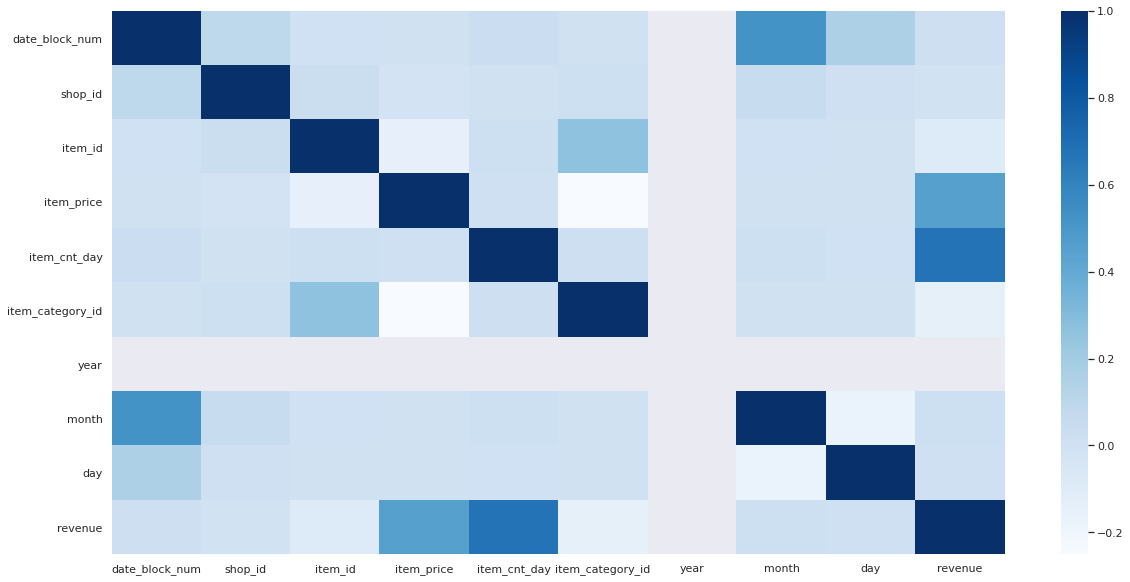

In [48]:
plt.figure(figsize = (20, 10))
sns.heatmap(salestrain_df_combined.corr(), cmap='Blues')
plt.show()

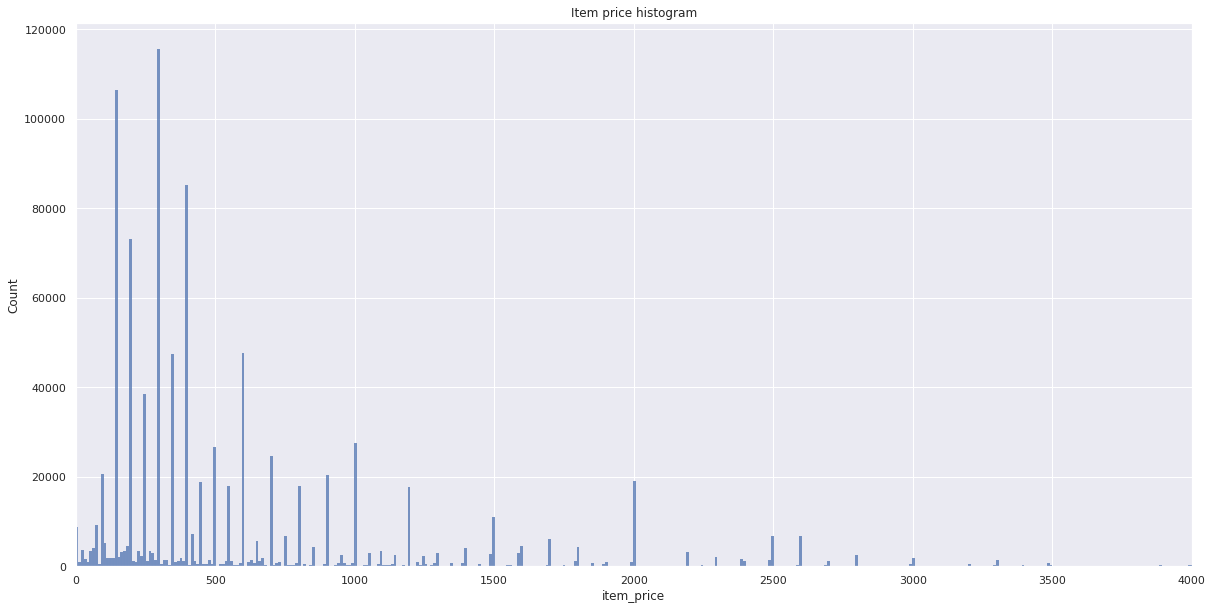

In [49]:
# plotting histogram of the price of items
# some high ticket items, lots 
fig, ax = plt.subplots(figsize=(20, 10))
sns.histplot(x='item_price', data=salestrain_df)
plt.xlim(0, 4000)
plt.title('Item price histogram')
plt.show()

create item price bands to graph

whisker plot with yearly revenue?

pair plot variation? diag_kind='hist'

sns.scatterplot

## Rolling window K-fold cross-validation

In [64]:
salestrain_df_combined.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'year', 'month', 'day', 'revenue'],
      dtype='object')

In [65]:
# setting X and y to be split
X = salestrain_df_combined['date']
y = salestrain_df_combined['revenue']

In [66]:
# creating the time series split, one split for every month in the year
tscv = TimeSeriesSplit(n_splits = 12)

TimeSeriesSplit(max_train_size=None, n_splits=12)

In [67]:
# looping through every time series split 
for train_index, test_index in tscv.split(X):
  print(f'TRAIN SHAPE: {train_index.shape} TEST SHAPE: {test_index.shape}')
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[train_index]

TRAIN SHAPE: (74798,) TEST SHAPE: (74797,)
TRAIN SHAPE: (149595,) TEST SHAPE: (74797,)
TRAIN SHAPE: (224392,) TEST SHAPE: (74797,)
TRAIN SHAPE: (299189,) TEST SHAPE: (74797,)
TRAIN SHAPE: (373986,) TEST SHAPE: (74797,)
TRAIN SHAPE: (448783,) TEST SHAPE: (74797,)
TRAIN SHAPE: (523580,) TEST SHAPE: (74797,)
TRAIN SHAPE: (598377,) TEST SHAPE: (74797,)
TRAIN SHAPE: (673174,) TEST SHAPE: (74797,)
TRAIN SHAPE: (747971,) TEST SHAPE: (74797,)
TRAIN SHAPE: (822768,) TEST SHAPE: (74797,)
TRAIN SHAPE: (897565,) TEST SHAPE: (74797,)


# Feature selection

Make features for MA: 7, 30, 60, 90 days, season, month

Convert into categorical - Store, Item

In [55]:
# item names with their revenue and sold count
item_names = salestrain_df_combined.groupby('item_name').agg({'revenue':'sum', 'item_cnt_day':'count'}).reset_index().rename(columns={'item_name': 'Item Name', 'revenue': 'Revenue', 'item_cnt_day': 'Number of Sales'})
item_names.head()

,Item Name,Revenue,Number of Sales
0,"""Operation Bagration» [PC, Digital Version]",630.0,2
1,"""Operation Dead Snow"" 2 (Region)",56.0,2
2,& Rosenbaum LEPSE GREGORY ALEXANDER pure frate...,21356.0,110
3,& Rosenbaum LEPSE GREGORY ALEXANDER pure frate...,33711.0,99
4,* Micah Jumanji Amores Perros,189.0,1


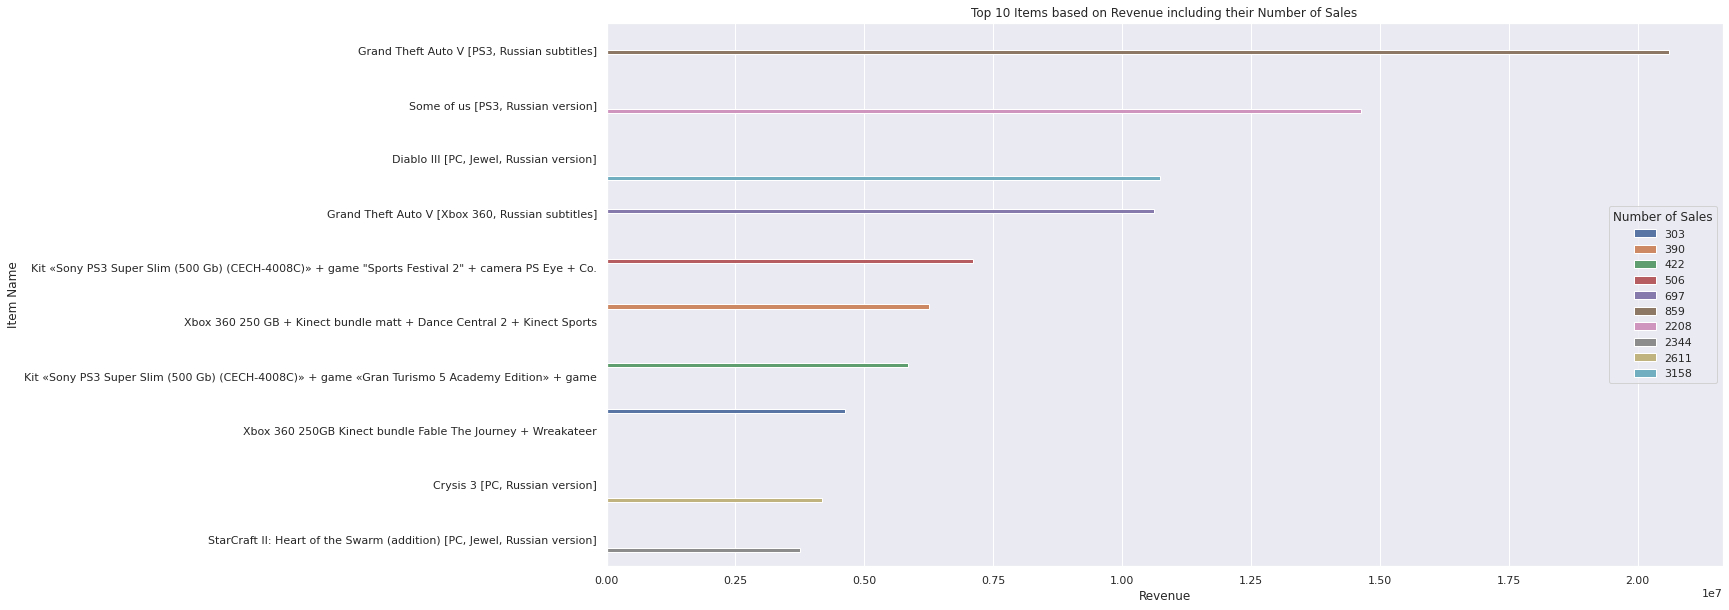

In [56]:
# top 10 items based on their revenue
top10_revenue = item_names.nlargest(10, 'Revenue')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_revenue, hue='Number of Sales', x='Revenue', y='Item Name')
plt.title("Top 10 Items based on Revenue including their Number of Sales")
plt.show()

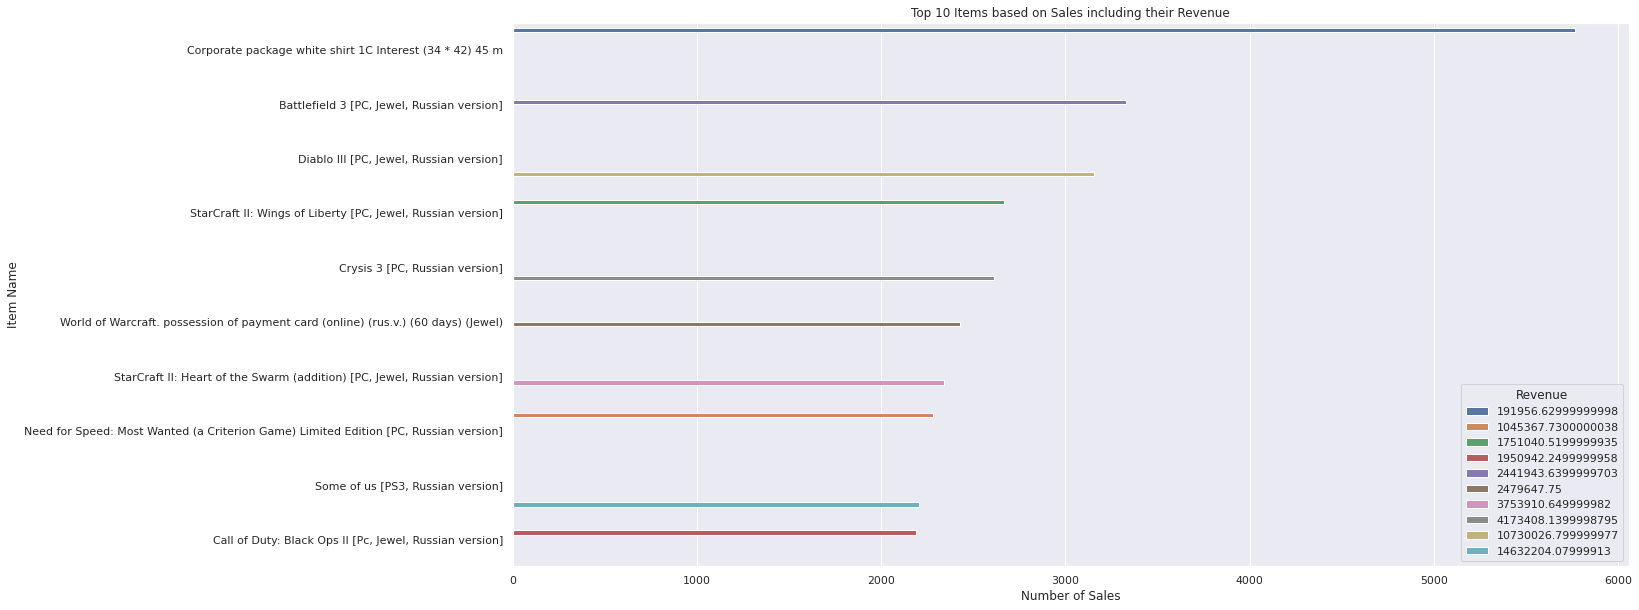

In [57]:
# top 10 items based on their revenue
top10_sales = item_names.nlargest(10, 'Number of Sales')

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(data=top10_sales, x='Number of Sales', y='Item Name', hue='Revenue')
plt.title("Top 10 Items based on Sales including their Revenue")
plt.show()

In [58]:
# category names and how many items in it.
category_names = salestrain_df_combined.groupby(['item_category_name']).agg({'item_name':'count'}).reset_index().rename(columns={'item_category_name': 'Category Name','item_name': 'Number of Items'})
category_names.head()

,Category Name,Number of Items
0,Accessories - PS2,2
1,Accessories - PS3,7515
2,Accessories - PS4,2147
3,Accessories - PSP,1583
4,Accessories - PSVita,3172


In [59]:
#Find total sales by item
total_sales_by_item = salestrain_df_combined.groupby('item_id')['item_cnt_day'].sum().reset_index()

#Sort descending
total_sales_by_item.sort_values(by='item_cnt_day',ascending=False,inplace=True)
total_sales_by_item.head()

,item_id,item_cnt_day
13095,20949.0,38693.0
1654,2808.0,11045.0
2199,3732.0,8110.0
10471,16787.0,5700.0
4046,6738.0,5560.0


In [60]:
#Merge together so we can get item_name with total sales values
total_sales_by_item_with_name = total_sales_by_item.merge(items_df[['item_name','item_id']],on='item_id')
total_sales_by_item_with_name.head()

,item_id,item_cnt_day,item_name
0,20949.0,38693.0,Corporate package white shirt 1C Interest (34 ...
1,2808.0,11045.0,"Diablo III [PC, Jewel, Russian version]"
2,3732.0,8110.0,"Grand Theft Auto V [PS3, Russian subtitles]"
3,16787.0,5700.0,"Some of us [PS3, Russian version]"
4,6738.0,5560.0,StarCraft II: Heart of the Swarm (addition) [P...


In [61]:
#Histogram - not very exciting
fig, ax = plt.subplots(figsize=(20,10))
plt.hist(x = total_sales_by_item_with_name['item_name'], bins=10)
plt.show()

KeyboardInterrupt: ignored

In [ ]:
#Get sales by item, by date - again, not very exciting,so I also used fillna()
sales_totals_by_day = salestrain_df_combined.pivot_table(index='item_id',columns=['year', 'month', 'day'],values='item_cnt_day').fillna(0)

In [ ]:
#Clean up the multi-level index
sales_totals_by_day.columns=sales_totals_by_day.columns.droplevel().droplevel()

In [ ]:
sales_totals_by_day.head()

In [ ]:
#Shape of the resulting DF - items x days
sales_totals_by_day.shape

In [ ]:
#Transpose this
sales_totals_by_day_transposed = sales_totals_by_day.transpose()

In [ ]:
sales_totals_by_day_transposed.head()

In [ ]:
# Recommendation engine - find the closest matches to an item in terms of daily sales
# Similar to finding similar movies based on movie rating

#Select a popular item
selected_item=2808

In [ ]:
#Pull out the column of that day's sales
selected_item_sales=sales_totals_by_day_transposed[selected_item]

In [ ]:
#Run correlation with every other column to find similar sales patterns
similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)

In [ ]:
#Convert from a series to a DF
similarItems_df=pd.DataFrame(similarItems)

In [ ]:
similarItems_df.head()

In [ ]:
#Rename columns
similarItems_df.columns=['similarity']

In [ ]:
similarItems_df.head()

In [ ]:
#Merge back item names
similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')

In [ ]:
#Sort
similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)

In [ ]:
#The top results for item 2808 seem to make some sense (games), but they also include programming books and other things-inconclusive?
similarItems_df_sorted.head(20)

In [ ]:
#Function to return the values:

def find_similar_based_on_daily_sales(selected_item,sales_totals_by_day_transposed=sales_totals_by_day_transposed):
    selected_item_sales=sales_totals_by_day_transposed[selected_item]
    similarItems = sales_totals_by_day_transposed.corrwith(selected_item_sales)
    similarItems_df=pd.DataFrame(similarItems)
    similarItems_df.columns=['similarity']
    similarItems_df=similarItems_df.merge(items_df[['item_name','item_id']],left_index=True,right_on='item_id')
    similarItems_df_sorted=similarItems_df.sort_values(by='similarity',ascending=False)
    print(similarItems_df_sorted.head(20))

In [ ]:
find_similar_based_on_daily_sales(2808)

In [ ]:
#What is similar to those corporate T-shirts?
find_similar_based_on_daily_sales(20949)

In [ ]:
#What is similar to those corporate T-shirts?
find_similar_based_on_daily_sales(4870)

In [ ]:
sales_totals_by_day_transposed[20949]

In [ ]:
#This item averaged 5 sales per day, max of 35, so it wasn't distorted by one overwhelmingly high corporate order
sales_totals_by_day_transposed[20949].describe()